<a href="https://colab.research.google.com/github/shohan007/DIS-soft-sensing-benchmarking-with-SVR-ANN/blob/main/Time_series_to_SVR_%26_ANN_(Vector).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [14]:
#Function to generate ML data set by shifting the data from 1 to 5 lag

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Freq%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Freq%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Freq%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [15]:
#Dataset
dataset=pd.read_excel('/content/vetch for svm_5data.xlsx')
values=dataset.iloc[:,5:16]
values.head(20)

,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz
0,0.173,-0.371,-1.070,-1.096,-1.270,-1.479,-1.532,-1.617,-1.534,-1.625,-1.603
1,0.120,-0.263,-1.059,-1.015,-1.150,-1.482,-1.516,-1.613,-1.581,-1.722,-1.587
2,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662
3,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685
4,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609
5,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391
6,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318
7,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258
8,1.259,0.423,-0.150,-0.669,-0.813,-1.080,-1.028,-1.184,-1.313,-1.289,-1.410
9,1.131,0.405,-0.260,-0.669,-0.628,-1.049,-1.106,-1.121,-1.355,-1.229,-1.353


In [39]:

# data splitting (last 10 row test data)

data = series_to_supervised(values,5)
#print(data)

#scale= preprocessing.MinMaxScaler()  #data normalizing
#data[data.columns] = scale.fit_transform(data)
#data

X=data.iloc[:, 1:-10]  
y=data.iloc[:,X.shape[1]:] #Last 10 column Y values

#Training Test split

X_train=X.iloc[1:-10,:].values
X_test=X.iloc[X_train.shape[0]:,:].values

y_train=y.iloc[1:-10,:].values      #last 10 row test and prediction data
y_test=y.iloc[y_train.shape[0]:,:].values

y_train_df=y.iloc[1:-10,:]
y_test_df=y.iloc[y_train.shape[0]:,:]

data.head()

,Freq1(t-5),Freq2(t-5),Freq3(t-5),Freq4(t-5),Freq5(t-5),Freq6(t-5),Freq7(t-5),Freq8(t-5),Freq9(t-5),Freq10(t-5),Freq11(t-5),Freq1(t-4),Freq2(t-4),Freq3(t-4),Freq4(t-4),Freq5(t-4),Freq6(t-4),Freq7(t-4),Freq8(t-4),Freq9(t-4),Freq10(t-4),Freq11(t-4),Freq1(t-3),Freq2(t-3),Freq3(t-3),Freq4(t-3),Freq5(t-3),Freq6(t-3),Freq7(t-3),Freq8(t-3),Freq9(t-3),Freq10(t-3),Freq11(t-3),Freq1(t-2),Freq2(t-2),Freq3(t-2),Freq4(t-2),Freq5(t-2),Freq6(t-2),Freq7(t-2),Freq8(t-2),Freq9(t-2),Freq10(t-2),Freq11(t-2),Freq1(t-1),Freq2(t-1),Freq3(t-1),Freq4(t-1),Freq5(t-1),Freq6(t-1),Freq7(t-1),Freq8(t-1),Freq9(t-1),Freq10(t-1),Freq11(t-1),Freq1(t),Freq2(t),Freq3(t),Freq4(t),Freq5(t),Freq6(t),Freq7(t),Freq8(t),Freq9(t),Freq10(t),Freq11(t)
5,0.173,-0.371,-1.070,-1.096,-1.270,-1.479,-1.532,-1.617,-1.534,-1.625,-1.603,0.120,-0.263,-1.059,-1.015,-1.150,-1.482,-1.516,-1.613,-1.581,-1.722,-1.587,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391
6,0.120,-0.263,-1.059,-1.015,-1.150,-1.482,-1.516,-1.613,-1.581,-1.722,-1.587,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318
7,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258
8,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258,1.259,0.423,-0.150,-0.669,-0.813,-1.080,-1.028,-1.184,-1.313,-1.289,-1.410
9,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258,1.259,0.423,-0.150,-0.669,-0.813,-1.080,-1.028,-1.184,-1.313,-1.289,-1.410,1.131,0.405,-0.260,-0.669,-0.628,-1.049,-1.106,-1.121,-1.355,-1.229,-1.353


In [41]:
# Create the SVR regressor
svr = SVR(C=1, epsilon=.1, kernel = 'linear')

# Create the Multioutput Regressor
mor = MultiOutputRegressor(svr)
mor = mor.fit(X_train, y_train)

# Generate predictions for testing data
y_pred = mor.predict(X_test)

#prediction of test sata
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Pred Freq1(t)', 1: 'Pred Freq2(t)',2: 'Pred Freq3(t)', 3: 'Pred Freq4(t)',4: 'Pred Freq5(t)', 5: 'Pred Freq6(t)',6: 'Pred Freq7(t)', 7: 'Pred Freq8(t)',8: 'Pred Freq9(t)', 9: 'Pred Freq10(t)',10: 'Pred Freq11(t)', 11: 'Pred Freq1(t)',}, inplace=True)
#predictions_y
#y_test_df.head()  

#predictions of training data
predictions_x=pd.DataFrame(mor.predict(X_train))

# Calculate the root mean square error (RMSE) for test and training data
N = len(y_test)
rmse_test = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_y).flatten())**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).flatten().max()-np.array(y_test_df).flatten().min())
print("nRMSE TEST: ", nRMSE_test)    

N = len(y_train)
rmse_train = np.sqrt(np.sum((np.array(y_train).flatten() - np.array(predictions_x).flatten())**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).flatten().max()-np.array(y_train_df).flatten().min())
print("nRMSE train: ", nRMSE_train)

print("RMSE TEST: ", rmse_test) 
print("RMSE train: ", rmse_train)

nRMSE TEST:  0.46843302366118517
nRMSE train:  0.14220562663583614
RMSE TEST:  1.914954200726925
RMSE train:  0.42562144052105755


In [42]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index.head()

,Pred Freq1(t),Pred Freq2(t),Pred Freq3(t),Pred Freq4(t),Pred Freq5(t),Pred Freq6(t),Pred Freq7(t),Pred Freq8(t),Pred Freq9(t),Pred Freq10(t),Pred Freq11(t),Freq1(t),Freq2(t),Freq3(t),Freq4(t),Freq5(t),Freq6(t),Freq7(t),Freq8(t),Freq9(t),Freq10(t),Freq11(t)
44,0.774401,-0.055985,-0.420672,-1.049554,-0.933703,-1.145469,-1.250409,-1.259458,-1.354472,-1.391432,-1.337522,0.674,-0.121,-0.521,-1.150,-0.906,-1.246,-1.351,-1.360,-1.455,-1.492,-1.438
45,1.354264,1.070378,0.362996,0.036037,-0.112472,-0.375981,-0.585910,-0.529964,-0.835535,-0.770974,-0.734288,2.315,1.716,1.456,1.439,1.042,0.941,0.792,0.795,0.751,0.713,0.795
46,1.639105,2.055786,0.963398,1.425274,0.665158,0.924327,0.584911,0.518832,0.238152,0.364695,0.464735,2.287,1.787,1.447,1.355,1.057,1.011,0.853,0.866,0.796,0.753,0.779
47,1.978108,2.205801,0.982661,1.644162,0.921673,0.813107,0.753652,0.599390,0.469857,0.594374,0.693656,2.596,1.711,1.407,1.122,0.998,0.970,0.824,0.861,0.749,0.809,0.736
48,1.629711,2.368726,1.279852,2.079889,0.978839,0.928913,1.009856,0.751136,0.624121,0.738320,0.723909,2.557,1.993,1.533,1.249,1.123,1.008,0.873,0.817,0.761,0.705,0.744


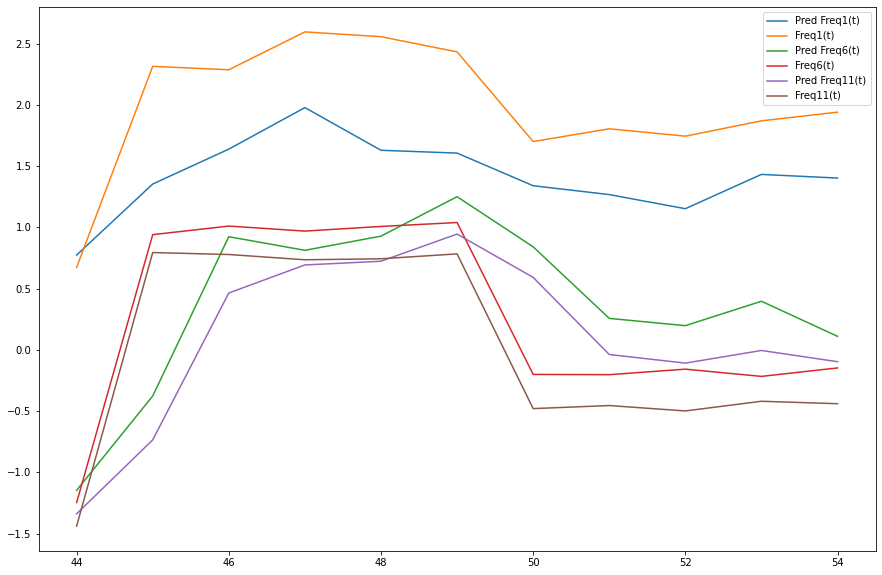

In [43]:
df_index[['Pred Freq1(t)','Freq1(t)','Pred Freq6(t)','Freq6(t)','Pred Freq11(t)','Freq11(t)']].plot(figsize=(15,10));

In [44]:
#With cross validation

from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(mor, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.216 (0.055)


##ANN

In [48]:
from numpy import asarray
from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense

#preparing dataset 

data = series_to_supervised(values,5)
#scale= preprocessing.MinMaxScaler()
#data[data.columns] = scale.fit_transform(data)
#data
#print(data)

X=data.iloc[:, 1:-10]  
y=data.iloc[:,X.shape[1]:] #Last 10 column Y value

#Training Test split

X_train=X.iloc[1:-10,:].values
X_test=X.iloc[X_train.shape[0]:,:].values

y_train=y.iloc[1:-10,:].values      #last 10 row test and prediction data
y_test=y.iloc[y_train.shape[0]:,:].values

y_train_df=y.iloc[1:-10,:]
y_test_df=y.iloc[y_train.shape[0]:,:]

data.head()

,Freq1(t-5),Freq2(t-5),Freq3(t-5),Freq4(t-5),Freq5(t-5),Freq6(t-5),Freq7(t-5),Freq8(t-5),Freq9(t-5),Freq10(t-5),Freq11(t-5),Freq1(t-4),Freq2(t-4),Freq3(t-4),Freq4(t-4),Freq5(t-4),Freq6(t-4),Freq7(t-4),Freq8(t-4),Freq9(t-4),Freq10(t-4),Freq11(t-4),Freq1(t-3),Freq2(t-3),Freq3(t-3),Freq4(t-3),Freq5(t-3),Freq6(t-3),Freq7(t-3),Freq8(t-3),Freq9(t-3),Freq10(t-3),Freq11(t-3),Freq1(t-2),Freq2(t-2),Freq3(t-2),Freq4(t-2),Freq5(t-2),Freq6(t-2),Freq7(t-2),Freq8(t-2),Freq9(t-2),Freq10(t-2),Freq11(t-2),Freq1(t-1),Freq2(t-1),Freq3(t-1),Freq4(t-1),Freq5(t-1),Freq6(t-1),Freq7(t-1),Freq8(t-1),Freq9(t-1),Freq10(t-1),Freq11(t-1),Freq1(t),Freq2(t),Freq3(t),Freq4(t),Freq5(t),Freq6(t),Freq7(t),Freq8(t),Freq9(t),Freq10(t),Freq11(t)
5,0.173,-0.371,-1.070,-1.096,-1.270,-1.479,-1.532,-1.617,-1.534,-1.625,-1.603,0.120,-0.263,-1.059,-1.015,-1.150,-1.482,-1.516,-1.613,-1.581,-1.722,-1.587,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391
6,0.120,-0.263,-1.059,-1.015,-1.150,-1.482,-1.516,-1.613,-1.581,-1.722,-1.587,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318
7,-0.058,-0.395,-1.100,-0.951,-0.987,-1.454,-1.494,-1.558,-1.580,-1.739,-1.662,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258
8,-0.026,-0.233,-1.083,-0.915,-1.119,-1.433,-1.611,-1.583,-1.553,-1.662,-1.685,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258,1.259,0.423,-0.150,-0.669,-0.813,-1.080,-1.028,-1.184,-1.313,-1.289,-1.410
9,-0.041,-0.166,-1.005,-0.793,-1.226,-1.455,-1.541,-1.576,-1.553,-1.638,-1.609,1.293,0.583,-0.187,-0.548,-0.737,-1.024,-1.084,-1.211,-1.238,-1.236,-1.391,1.446,0.414,-0.133,-0.638,-0.949,-0.984,-1.031,-1.184,-1.300,-1.285,-1.318,1.162,0.595,-0.166,-0.580,-0.607,-0.992,-1.083,-1.212,-1.299,-1.258,-1.258,1.259,0.423,-0.150,-0.669,-0.813,-1.080,-1.028,-1.184,-1.313,-1.289,-1.410,1.131,0.405,-0.260,-0.669,-0.628,-1.049,-1.106,-1.121,-1.355,-1.229,-1.353


In [49]:
# use mlp for prediction on multi-output regression

# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(120, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(60, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

# get model
model = get_model(n_inputs, n_outputs)

# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=1000)

# make a prediction for new data
yhat = model.predict(X_test)
#print('Predicted: %s' % yhat[0])

#nRMSE
#prediction of test sata
predictions_y=pd.DataFrame(yhat)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Pred Freq1(t)', 1: 'Pred Freq2(t)',2: 'Pred Freq3(t)', 3: 'Pred Freq4(t)',4: 'Pred Freq5(t)', 5: 'Pred Freq6(t)',6: 'Pred Freq7(t)', 7: 'Pred Freq8(t)',8: 'Pred Freq9(t)', 9: 'Pred Freq10(t)',10: 'Pred Freq11(t)', 11: 'Pred Freq1(t)',}, inplace=True)
#predictions_y
#y_test_df.head()  

#predictions of training data
predictions_x=pd.DataFrame(model.predict(X_train))

# Calculate the root mean square error (RMSE) for test and training data
N = len(y_test)
rmse_test = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_y).flatten())**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).flatten().max()-np.array(y_test_df).flatten().min())
print("nRMSE TEST: ", nRMSE_test)    

N = len(y_train)
rmse_train = np.sqrt(np.sum((np.array(y_train).flatten() - np.array(predictions_x).flatten())**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).flatten().max()-np.array(y_train_df).flatten().min())
print("nRMSE train: ", nRMSE_train)

print("RMSE TEST: ", rmse_test) 
print("RMSE train: ", rmse_train)

nRMSE TEST:  0.6414177022436578
nRMSE train:  0.037177464608455085
RMSE TEST:  2.6221155667720732
RMSE train:  0.11127215157310606


In [50]:
# K cross validation for the ANN network
X=data.iloc[:, 1:-10].values 
y=data.iloc[:,X.shape[1]:].values

# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(120, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(60, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>0.590
>0.279
>0.145
>0.269
>0.303
>0.134
>0.384
>0.276
>0.233
>0.222
>0.194
>0.461
>0.442
>0.176
>0.235
>0.163
>0.338
>0.353
>0.213
>0.243
>0.282
>0.162
>0.195
>0.247
>0.217
>0.165
>0.554
>0.518
>0.191
>0.269
MAE: 0.282 (0.121)


In [ ]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index.head(20)

,Pred Freq1(t),Pred Freq2(t),Pred Freq3(t),Pred Freq4(t),Pred Freq5(t),Pred Freq6(t),Pred Freq7(t),Pred Freq8(t),Pred Freq9(t),Pred Freq10(t),Pred Freq11(t),Freq1(t),Freq2(t),Freq3(t),Freq4(t),Freq5(t),Freq6(t),Freq7(t),Freq8(t),Freq9(t),Freq10(t),Freq11(t)
44,0.642808,-0.147055,-0.543601,-1.161619,-0.929731,-1.275491,-1.394618,-1.341388,-1.413766,-1.494541,-1.412254,0.674,-0.121,-0.521,-1.150,-0.906,-1.246,-1.351,-1.360,-1.455,-1.492,-1.438
45,1.651850,0.577059,-0.350715,0.068115,-0.244093,-0.031179,-1.125192,-0.145316,-0.238102,-0.675147,-0.523549,2.315,1.716,1.456,1.439,1.042,0.941,0.792,0.795,0.751,0.713,0.795
46,1.778900,1.628088,1.433931,1.411664,1.557295,-0.041019,0.677385,1.036789,1.792676,0.711609,1.222632,2.287,1.787,1.447,1.355,1.057,1.011,0.853,0.866,0.796,0.753,0.779
47,2.240369,1.404575,0.894940,1.557571,1.418553,-0.038473,0.844238,0.613617,0.994597,0.489170,1.307670,2.596,1.711,1.407,1.122,0.998,0.970,0.824,0.861,0.749,0.809,0.736
48,1.829165,0.714727,0.581210,0.886112,0.935671,0.355246,0.628774,0.789231,0.856993,0.415603,0.866402,2.557,1.993,1.533,1.249,1.123,1.008,0.873,0.817,0.761,0.705,0.744
49,2.317325,0.953885,-0.140961,0.467166,1.023466,-0.473002,-0.482946,-0.153265,0.175266,-0.008655,1.027652,2.433,1.847,1.371,1.321,1.198,1.040,0.852,0.810,0.838,0.758,0.784
50,2.017206,-0.358845,-0.615263,-0.294974,-0.160181,-1.705940,-2.180993,-1.766555,-1.755475,-1.685351,-0.615454,1.701,0.959,0.366,0.079,-0.155,-0.200,-0.272,-0.419,-0.380,-0.442,-0.479
51,1.914206,-0.010740,-0.411788,-0.190059,-0.361472,-1.167686,-1.667466,-1.582061,-1.468709,-1.309253,-0.956759,1.805,0.967,0.308,0.178,0.188,-0.202,-0.309,-0.406,-0.380,-0.398,-0.454
52,1.742399,-0.138699,-0.228347,-0.263809,-0.643001,-0.591873,-1.345961,-0.888277,-1.479222,-1.364176,-0.709517,1.745,1.006,0.328,0.035,-0.048,-0.157,-0.294,-0.411,-0.437,-0.439,-0.498
53,1.961246,0.773915,0.429121,0.176897,-0.469302,-0.547590,-0.207292,-1.044399,-1.394588,-0.767896,-0.690470,1.870,0.895,0.332,0.175,0.065,-0.216,-0.376,-0.391,-0.381,-0.550,-0.419


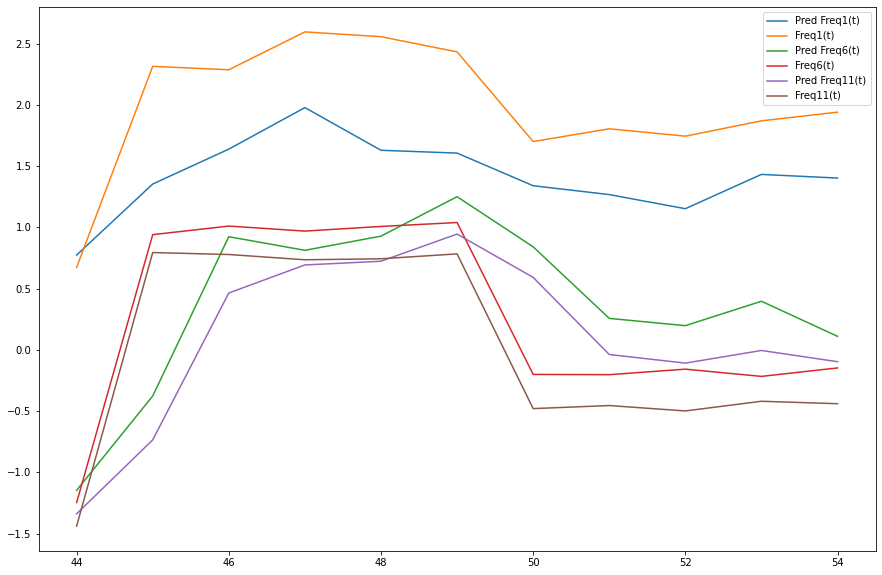

In [51]:
df_index[['Pred Freq1(t)','Freq1(t)','Pred Freq6(t)','Freq6(t)','Pred Freq11(t)','Freq11(t)']].plot(figsize=(15,10));